In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = ['right', 'left', 'jump']

data = np.concatenate([
    np.load(r'angle1\왼.npy'),
    np.load(r'angle1\오.npy'),
    np.load(r'angle1\점프.npy')
], axis=0)

data.shape

(49311, 30, 137)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(49311, 30, 136)
(49311,)


In [4]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(49311, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(44379, 30, 136) (44379, 3)
(4932, 30, 136) (4932, 3)


In [6]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                51456     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 53,635
Trainable params: 53,635
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=2,callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)


Epoch 1/2
1387/1387 [==============================] - 26s 18ms/step - loss: 1.7949 - acc: 0.9335 - val_loss: 0.0626 - val_acc: 0.9899

Epoch 1: val_acc improved from -inf to 0.98986, saving model to models\model.h5
Epoch 2/2
1387/1387 [==============================] - 24s 17ms/step - loss: 0.0250 - acc: 0.9943 - val_loss: 0.0129 - val_acc: 0.9978

Epoch 2: val_acc improved from 0.98986 to 0.99777, saving model to models\model.h5


In [8]:
model.save("model3.h5")

TypeError: 'tuple' object is not callable

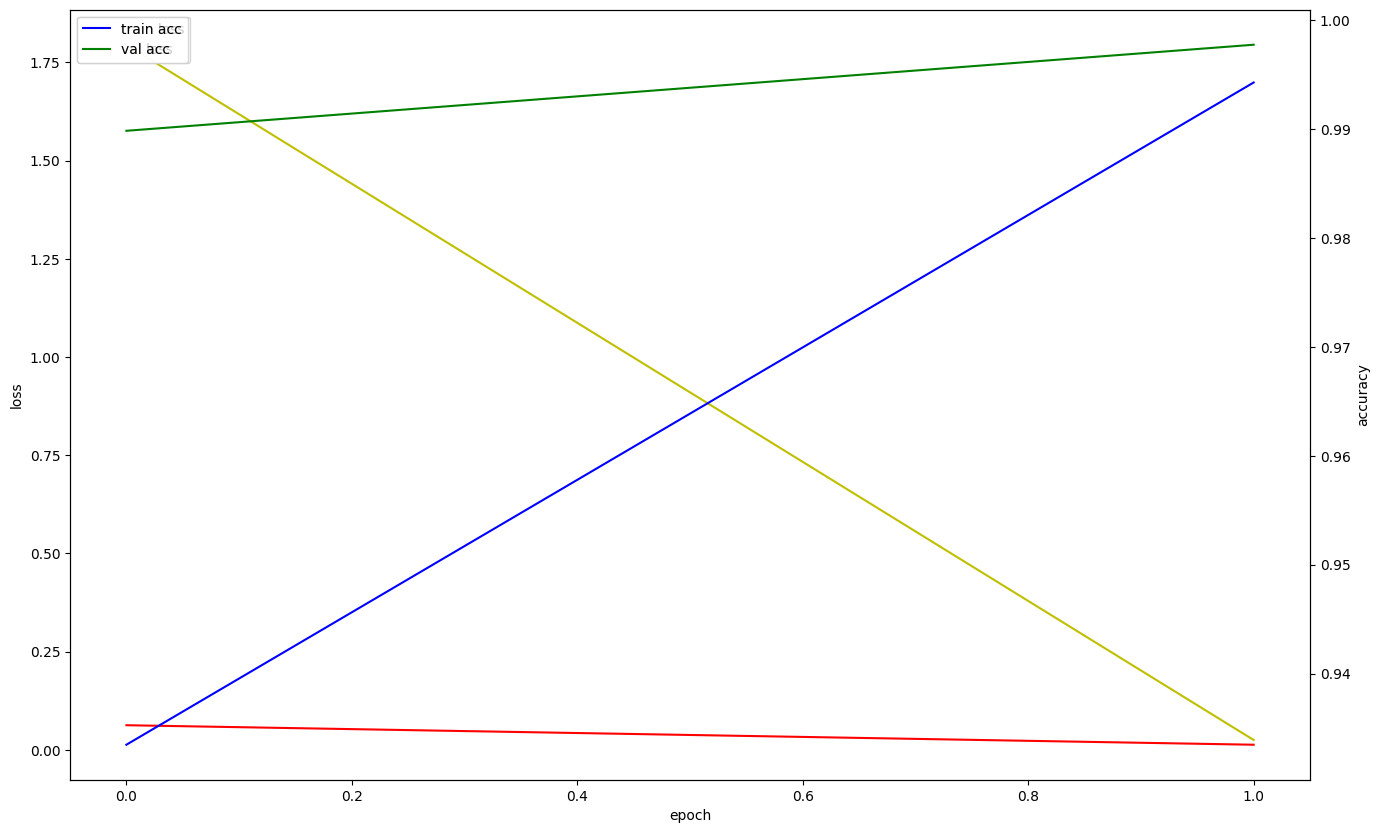

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')
a = np.array(history.history['loss']).shape()
print(a)
plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('model3.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

155/155 [==============================] - 1s 3ms/step


array([[[3293,    5],
        [   4, 1630]],

       [[3298,    1],
        [   2, 1631]],

       [[3262,    5],
        [   5, 1660]]], dtype=int64)